# Select sub region with xarray on 2d coordinates

We use a static dataset for convenience:

In [44]:
import xarray as xr
import numpy as np

file = "/pool/data/CORDEX/data/cordex/output/EUR-11/GERICS/ECMWF-ERAINT/evaluation/r0i0p0/GERICS-REMO2015/v1/fx/orog/v20180813/orog_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx.nc"

ds = xr.open_dataset(file)

pollat = ds.rotated_latitude_longitude.grid_north_pole_latitude
pollon = ds.rotated_latitude_longitude.grid_north_pole_longitude

# more or less Germany
min_lon = 5
min_lat = 47
max_lon = 16
max_lat = 55

In [45]:
import numpy as np

# rotation function adapted from https://py-cordex.readthedocs.io/en/latest/cordex.html#cordex.domain.rotated_coord_transform

def rotate(lon, lat, pollon, pollat, direction='rot2geo'):
    
    theta = 90. - pollat
    phi = pollon + 180.  
    
    # Convert degrees to radians
    phi = np.deg2rad(phi)
    theta = np.deg2rad(theta)
    
    lon = np.deg2rad(lon)
    lat = np.deg2rad(lat)
    
    x = np.cos(lon) * np.cos(lat)
    y = np.sin(lon) * np.cos(lat)
    z = np.sin(lat)

    # Regular -> Rotated
    if direction == 'geo2rot':

        x_new = (np.cos(theta) * np.cos(phi) * x +
                 np.cos(theta) * np.sin(phi) * y +
                 np.sin(theta) * z)
        y_new = (- np.sin(phi) * x +
                   np.cos(phi) * y)
        z_new = (- np.sin(theta) * np.cos(phi) * x -
                   np.sin(theta) * np.sin(phi) * y +
                   np.cos(theta) * z)

    # Rotated -> Regular
    elif direction == 'rot2geo':
    
        phi = - phi
        theta = - theta
    
        x_new = (np.cos(theta) * np.cos(phi) * x +
                 np.sin(phi) * y +
                 np.sin(theta) * np.cos(phi) * z)
        y_new = (- np.cos(theta) * np.sin(phi) * x +
                   np.cos(phi) * y -
                   np.sin(theta) * np.sin(phi) * z)
        z_new = (- np.sin(theta) * x +
                   np.cos(theta) * z)

    # Convert cartesian back to spherical coordinates
    lon_new = np.arctan2(y_new, x_new)
    lat_new = np.arcsin(z_new)
    
    return np.rad2deg(lon_new), np.rad2deg(lat_new)

In [46]:
min_rlon, min_rlat = rotate(min_lon, min_lat, pollon, pollat, "geo2rot")
max_rlon, max_rlat = rotate(max_lon, max_lat, pollon, pollat, "geo2rot")
min_rlon, min_rlat, max_rlon, max_rlat

(-8.83694507591009,
 -2.9730985955903164,
 -1.1501829203811094,
 4.265545906214869)

We can select sub regions using the original 1d rotated coordinates using slices

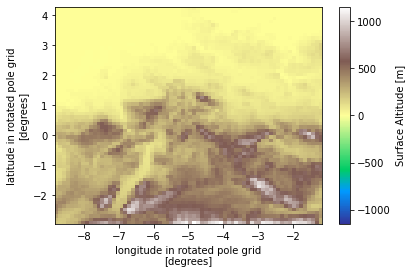

In [47]:
# select by using coordinates and slices
lon_slice = slice(min_rlon, max_rlon)
lat_slice = slice(min_rlat, max_rlat)
ds_sub_rot = ds.sel(rlon=lon_slice, rlat=lat_slice)
ds_sub_rot.orog.plot(cmap="terrain")

### select by masking curvilinear coordinates

We can also select using 2d coordinates (curvilinear). We use a masking approach here, see also
* https://github.com/pydata/xarray/issues/475
* https://gis.stackexchange.com/questions/353698/how-to-clip-an-xarray-to-a-smaller-extent-given-the-lat-lon-coordinates

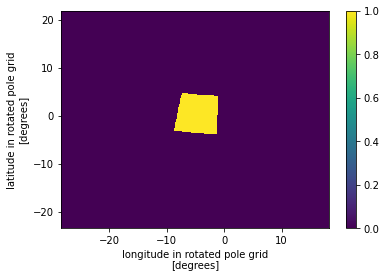

In [48]:
mask = (ds.lon >= min_lon) & (ds.lon <= max_lon) & (ds.lat >= min_lat) & (ds.lat <= max_lat)
mask.plot()

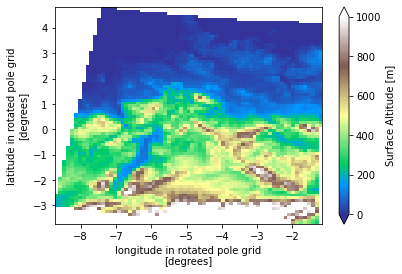

In [49]:
ds_sub = ds.where(mask, drop=True)
ds_sub.orog.plot(cmap="terrain", vmin=0, vmax=1000)

### compare to `cdo.sellonlatbox`

first: plot our selection using the rotated coordinates

In [52]:
def plot(da, title=''):
    %matplotlib inline
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    projection = ccrs.PlateCarree()
    transform = ccrs.RotatedPole(pole_latitude=pollat, pole_longitude=pollon)
    #ax = plt.axes(projection=projection)
    ax = plt.axes(projection=transform)
    #ax.set_extent([ds_sub.rlon.min(), ds_sub.rlon.max(), ds_sub.rlat.min(), ds_sub.rlat.max()], crs=transform)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                      xlocs=range(-180,180,1), ylocs=range(-90,90,1))
    da.plot(ax=ax, cmap='terrain', transform=transform, vmin=-200, vmax=1000, x='rlon', y='rlat')
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cf.BORDERS)
    ax.set_title('')

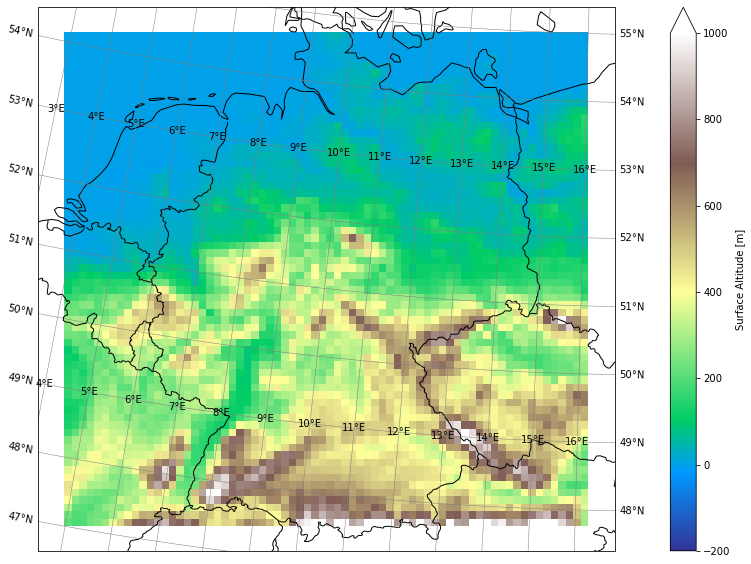

In [54]:
plot(ds_sub_rot.orog)

second: plot our selection using the 2d global coordinates

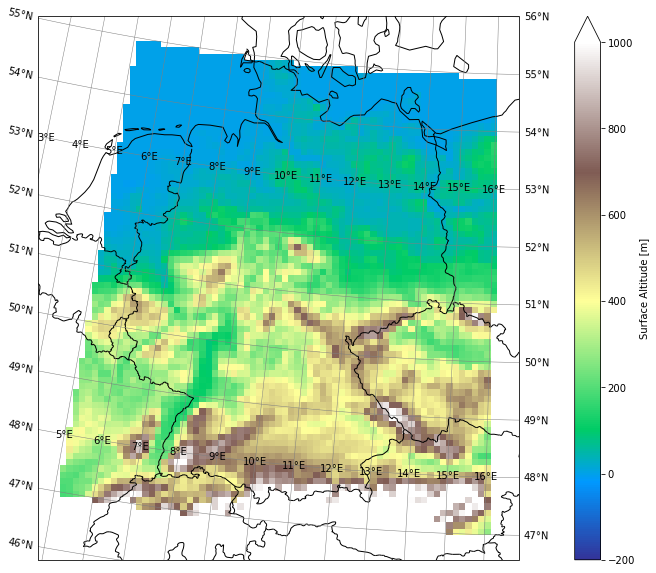

In [55]:
plot(ds_sub.orog)

compare to `cdo.sellonlatbox`

In [56]:
import os
cmd = ('cdo sellonlatbox,{},{},{},{} {} sellonlat.nc'.format(min_lon, max_lon, min_lat, max_lat, file))
os.system(cmd)

0

In [57]:
ds_cdo = xr.open_dataset('sellonlat.nc')
ds_cdo

<xarray.Dataset>
Dimensions:                     (rlat: 78, rlon: 69, vertices: 4)
Coordinates:
    lon                         (rlat, rlon) float32 ...
    lat                         (rlat, rlon) float32 ...
  * rlon                        (rlon) float64 -8.685 -8.575 ... -1.315 -1.205
  * rlat                        (rlat) float64 -3.685 -3.575 ... 4.675 4.785
Dimensions without coordinates: vertices
Data variables:
    lon_bnds                    (rlat, rlon, vertices) float32 ...
    lat_bnds                    (rlat, rlon, vertices) float32 ...
    rotated_latitude_longitude  int32 ...
    orog                        (rlat, rlon) float32 ...
Attributes: (12/31)
    CDI:                            Climate Data Interface version 1.9.6 (htt...
    history:                        Wed May 12 11:08:17 2021: cdo sellonlatbo...
    source:                         GERICS-REMO2015
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    Conventions:                    CF-1.4
    institute_id:                   GERICS
    ...                             ...
    table_id:                       Table fx (Sept 2013) 54b02165bac4f892dfda...
    title:                          GERICS-REMO2015 model output prepared for...
    modeling_realm:                 atmos
    realization:                    0
    cmor_version:                   2.9.1
    CDO:                            Climate Data Operators version 1.9.6 (htt...

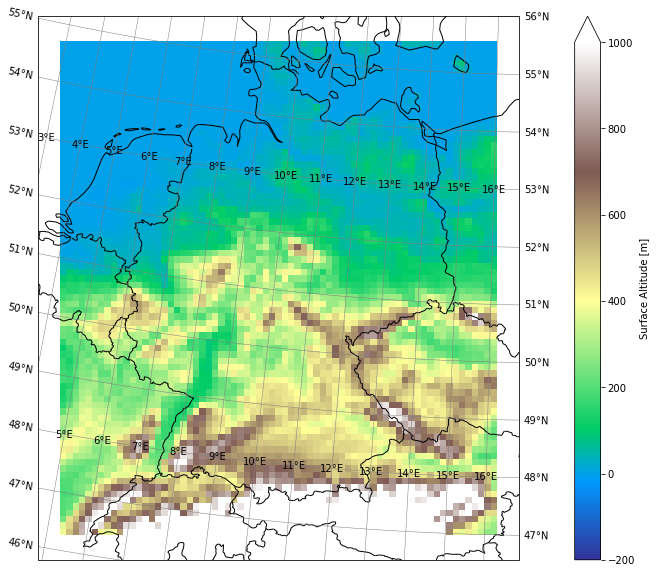

In [60]:
plot(ds_cdo.orog)

In [63]:
min_lon, min_lat, max_lon, max_lat

(5, 47, 16, 55)

It seems that cdo uses the global lon lat coordinates for selection (see also https://code.mpimet.mpg.de/boards/1/topics/1491). Note, that we still get coordinates that are outside our original selection (e.g., the corners).